*Simple Categorization Example*

This example creates a neural network that categorizes an integer as divisible by a given factor, e.g. 7.  Choosing higher numbers will result in a more sparse categorization, and allow experimenting with unbalanced data set categorizations.

it generates a list of random 16 bit integers, and expresses them as a list of bits for the neural network,
it also generates a list of 1 or 0 if the number is divisible by the factor

The resulting model can "predict" if a number is divisible by the factor.


*Required python software packages (install with pip):*

    numpy
    tensorflow
    matplotlib

*Conclusions*

One can train a model to categorize integers. Obviously this can be done more easily.




In [1]:
import numpy as np
# numpy is an essential library of numeric methods for python. It is also optimized
# for high performance.
# https://numpy.org/


nrows = 10000  # number of rows of data to generate
numEpochs = 1000 # maximum number of steps to run
factor = 4  # find integers that are evenly divisible by this - try different values!
            # you will find that powers of 2 (single bits) give the lowest error, other
            # values will require longer training periods, have higher errors, and may require
            # larger neural networks.


maxbits = 20 # size of integer to generate, 2**maxbits

#
# create a data set for y = mx + b, linearly related variables
# returns a tuple (x,y) of 'nrows' of correlated data
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
def create_data():
    
    # use the numpy library to create a random list
    # of numbers beteen 0 and 1.  np.random.uniform supplies this.
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
    
    number = np.random.randint(low=0, high=2**maxbits, size=nrows)
    
    # make an indicator category 0, 1 to indicate whether the number is evenly
    # divisible by 'factor'.  This is a very simple 'yes/no' categorization that
    # also represent toxic/nontoxic or other variables.    
    
    #  this is a "pythonic" way to compute the list.
    #
    #  val = [ f(x) for x in <list> ] results in a list 'val', with a size 
    #  the same as <list>, and each entry has the value of the function f(x) for the
    #  values x in < list>
    # example:
    #  val = [ 2*x for x in range(5)]
    #  result in val = [0, 2, 4, 6, 8]

    category = [num % factor & 1 for num in number]
    
    # create an array of 'maxbit' numbers corresponding to the bits in the integer
    # converting the integer into a list of bits.
    # Tensorflow will not otherwise look at bits in an integer, it would only
    # look to see the magnitude of the number
    bits = [[num >> k & 1 for k in range(maxbits - 1,-1,-1)] for num in number]
    
    # this "pythonic" computation of "bits" above is the equivalent of this loop:
    #
    # array to hold numbers as arrays of bits; this will be a list of lists.  
    # in python list = 'array' in other languages
    #bits     = []
    #for i in range(nrows):
        #entry = [number[i] >> k & 1 for k in range(maxbits - 1,-1,-1)]
        #bits.append(entry)    
    
    # return x,y as a tuple of numpy arrays
    return (np.array(bits), np.array(category))


x,y = create_data()

# print first 10 values to see the results
print('\nrandom integers each as a list of bits:')
print('x', x[:10])  # use python list syntax for first 10
print('\nthis above is the list of random numbers expressed as bits\n')
print('\narray of 1,0 if the number is divisible by', factor)
print('y', y[:10])
print('\nin this array 1 = divisible by %d,  0 = not evenly divisible' % (factor))



random integers each as a list of bits:
x [[0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1]
 [1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1]
 [0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1]
 [1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0]
 [1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1]
 [0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0]
 [1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0]
 [0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1]
 [1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1]]

this above is the list of random numbers expressed as bits


array of 1,0 if the number is divisible by 4
y [1 0 1 1 0 1 0 0 1 1]

in this array 1 = divisible by 4,  0 = not evenly divisible


In [2]:
nrows = int(1e6)  # number of rows of data to generate
numEpochs = 1000 # maximum number of steps to run
factor = 4  # find integers that are evenly divisible by this - try different values!
            # you will find that powers of 2 (single bits) give the lowest error, other
            # values will require longer training periods, have higher errors, and may require
            # larger neural networks.

batch_size = 1024

maxbits = 20 # size of integer to generate, 2**maxbits




import tensorflow.keras as keras
import numpy as np

"""
In big-data situations the data won't all fit in memory.  In that case we use a generator to
feed the data to Tensorflow in batches.  The data could be read from files or other sources.

In this example we generate a large number of random data, and create a linearly correlated data
set.  This can generate an "unlimited" size data set.
"""

# implement a class of type 'keras.utils.Sequence'
# https://keras.io/api/utils/python_utils/#sequence-class
class category_generator(keras.utils.Sequence):
    
    # initialize with batch_size and nrows - total data size
    # in a class all methods have the 'self' argument first.
    def __init__(self, batch_size, nrows):
        self.batch_size = batch_size # store batch_size in this class
        self.nrows = nrows
        self.batches = int(nrows/batch_size)
     
    # return number of batches this generator will produce
    def __len__(self):
        return self.batches
    
    
    # this method is called for each batch. In this example we ignore the
    # batch index, idx, because it is just random numbers. But in a real
    # situation you would retrieve a specific batch of data
    def __getitem__(self, idx):
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
        number = np.random.randint(low=0, high=2**maxbits, size=self.batch_size)
        bits = [[num >> k & 1 for k in range(maxbits - 1,-1,-1)] for num in number]
        category = [num % factor & 1 for num in number]
        
        return (np.array(bits), np.array(category))
       
    

In [3]:
"""
create the Neural Network model topology, which is one layer
"""
import tensorflow as tf
import tensorflow.keras as keras

def makeModel():

    # these two lines clear out the model so you can re-run 
    # the notebook with different conditions
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # https://keras.io/api/models/sequential/#sequential-class
    model = keras.Sequential()
    
    # https://keras.io/api/layers/core_layers/input/
    # it has to be the size of the list of bits for the integers.
    model.add(keras.Input(shape=(maxbits,)))
    
    # define layers of neurons.  There are many options that 
    # could be used here but the default are used for this simple example
    
    # https://keras.io/api/layers/core_layers/dense/
    # https://keras.io/api/layers/activations/#relu-function
    # the activation function modifies the network coefficients
    # https://keras.io/api/layers/normalization_layers/layer_normalization/
    
    # add more layers here to experiment with the neural network
    
    model.add(keras.layers.Dense(units=32, activation='relu'))
    #model.add(keras.layers.LayerNormalization()) # normalize coefficients to help stability
    model.add(keras.layers.Dense(units=1,  activation='sigmoid', name='output_layer'))
     
    # keras metrics - these are built in and keras will compute them for you to measure
    # the training.  They are not minimized during training; only the loss function(s)
    # are minimized.  
    tp = tf.keras.metrics.TruePositives()
    tn = tf.keras.metrics.TrueNegatives()
    fp = tf.keras.metrics.FalsePositives()
    fn = tf.keras.metrics.FalseNegatives()
    auc = tf.keras.metrics.AUC()
    
    # compile the network using default options.  The SGD optimizer
    # is good for general purpose, but would probably benefit from a custom
    # learning rate for this example
    # https://keras.io/api/optimizers/sgd/
    # 
    # see this for the loss function
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    #
    # the loss is function that will be minimized in the fitting process
    # https://keras.io/api/models/model_training_apis/#compile-method
    
    model.compile(optimizer='RMSprop', loss='binary_crossentropy',metrics=[tp,tn,fp,fn,auc])
    
    #show the model structure and layer size
    # the model has 2 trainable variables - enough for a perfect fit.
    model.summary()
    
    return model


In [4]:
%%time
"""
Put the elements together to generate data, make the model, and perform the training
"""


# create the random data

train_data = category_generator(batch_size, nrows)
validate_data = category_generator(batch_size, 1000)

# create the neural network
model = makeModel()


# this will monitor the error and stop if the delta is less than min_delta
# https://keras.io/api/callbacks/early_stopping/
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=1e-5,
    patience=1,
)

# fit the model with 500 steps.  There is a way to stop on specified change
# in error but this is a simple example.
#
# https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(
    x=train_data,    # dependent variable
    validation_data=validate_data,    # validation data
    epochs=numEpochs,  # try changing this to see how the error changes
    verbose=1,    # change this from 0-5 to get more info as the training proceeds
    callbacks=earlystop # this uses the 'earlystop' callback above to know when to stop
    )

print('num epochs', len(history.history['loss']))
loss, tp, tn, fp, fn, auc = model.evaluate(x,y, verbose = 0)
print('tp %3d tn %3d fp %3d fn %3d auc %4.3f loss %4.3f' % (tp, tn, fp, fn, auc, loss))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
976/976 [==============================] - 17s 17ms/step - loss: 0.1124 - true_positives: 493639.0000 - true_negatives: 492222.0000 - false_positives: 7080.0000 - false_negatives: 6483.0000 - auc: 0.9994
Epoch 2/1000
976/976 [==============================] - 17s 18ms/step - loss: 3.4063e-07 - true_positives: 499538.0000 - true_negatives: 499886.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - auc: 1.0000
Epoch 3/1000
976/976 [==============================] - 17s 18ms/step - loss: 1.

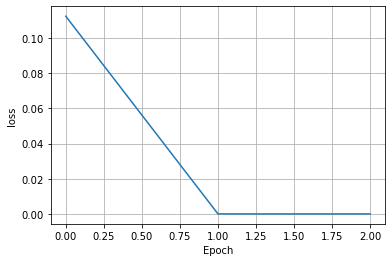

In [5]:
import matplotlib.pyplot as plt
# https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)

In [6]:
# example of predicted output. it is a floating point number that
# corresponds to the 'confidence' that the category is 1, or divisible.
pred = model.predict(x)
print(pred)

[[1.0000000e+00]
 [7.4651463e-10]
 [1.0000000e+00]
 ...
 [1.2890672e-09]
 [1.0000000e+00]
 [2.8907250e-09]]


In [15]:
# create new data for a test set
# this will generate a new data set not used for training
x,y = category_generator(1000,1000).__getitem__(0)

# compute metrics with model by predicting.
loss, tp, tn, fp, fn, auc = model.evaluate(x,y, verbose = 0)
print('accuracy metrics\n')
print('true positive  %5d false negative %5d\nfalse positive %5d true negative  %5d\n\nauc %4.3f' % (tp, fn, fp, tn, auc))

ppv = tp/(tp+fp+.01)
npv  =  tn/(tn+fn+.01)
F1  = 2*tp/(2*tp + fp + fn+.01)
print('positive predictive value %3.3f\nnegative predictive value %3.3f\nF1 score %3.3f' %(ppv, npv, F1))


accuracy metrics

true positive    504 false negative     0
false positive     0 true negative    496

auc 1.000
positive predictive value 1.000
negative predictive value 1.000
F1 score 1.000


In [16]:
# the coefficients can be retrieved by layer
model.get_weights()[0][0]
# you can see which bits have the highest coefficients, however it is difficult to interpret them.

array([-0.3249636 ,  0.0251838 , -0.14300272,  0.11157191,  0.09881493,
        0.26942256,  0.32359555,  0.03650909,  0.14816871,  0.08018949,
       -0.2649219 , -0.1323809 ,  0.35542455,  0.17975236, -0.00129553,
        0.4309723 ,  0.01143879,  0.18294294,  0.15230031,  0.2820894 ,
        0.2822877 ,  0.00130329, -0.02305873,  0.06828669, -0.03662499,
        0.39454198,  0.31400296,  0.40683198, -0.03600561, -0.26267895,
        0.12041561,  0.06198462], dtype=float32)